In [1]:
import os
current_path = os.getcwd()
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import numpy as np
np.seterr(all='raise')
import matplotlib.pyplot as plt
from tqdm import tqdm
import myInput
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
sys.path.append(current_path+'/../calculate_tangent/')

# 3D Polycrystal Initial Condition Generator

This notebook creates a 3D polycrystalline microstructure with domain size 200×200×200 containing three grains with periodic boundary conditions:

- **Grain 0**: A cylinder from the center of one grain boundary with radius of 50 voxels and height of 50, with a half-sphere on one side
- **Grain 1**: A cylinder along grain 0 until the other grain boundary
- **Grain 2**: Occupies the remaining space in the domain

In [ ]:

def generate_microstructure_cylinder(nx, ny, nz, cylinder_radius, cylinder_height, GB_radius):
    """
    Generate a microstructure with two grains:
    - Grain 0: Cylinder with half-sphere at the top
    - Grain 1: Extending cylinder from the top of grain 0 to the end of the domain
    - Grain 2: Remaining space
    """
    # Parameters for grain 0 (cylinder with half-sphere)
    start_z = (nz - cylinder_radius) // 2  # Starting z position (1/4 of domain)
    # Define center of the domain
    center_x, center_y = nx // 2, ny // 2

    # Create a mask for checking points inside cylinder and half-sphere
    def is_in_cylinder_with_halfsphere(x, y, z, center_x, center_y, start_z, radius, height, GB_radius):
        # Check if point is within the cylinder radius
        dist_xy = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        
        # Check for cylinder part
        if dist_xy <= radius and start_z <= z < start_z + height:
            return True
        
        # Check for half-sphere part (top of cylinder)
        if z >= start_z + height:
            dist_center = np.sqrt(dist_xy**2 + (z - (start_z + height - np.sqrt(GB_radius**2 - radius**2)))**2)
            if dist_xy <= radius and dist_center <= GB_radius:
                return True
            
        # Check for half-sphere part (bottom of cylinder)
        if z <= start_z:
            dist_center = np.sqrt(dist_xy**2 + (z - (start_z + np.sqrt(GB_radius**2 - radius**2)))**2)
            if dist_xy <= radius and dist_center <= GB_radius:
                return True
        
        return False

    # Create a mask for checking points inside extending cylinder
    def is_in_extending_cylinder_plus(x, y, z, center_x, center_y, start_z, radius, height, grain_base):
        # Check if point is within the cylinder radius
        dist_xy = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        
        # The extending cylinder goes from half-sphere end to the end of domain
        if dist_xy <= radius and z >= start_z + height and not grain_base[x,y,z]:
            return True
        
        return False
    
    # Create a mask for checking points inside extending cylinder
    def is_in_extending_cylinder_mines(x, y, z, center_x, center_y, start_z, radius, grain_base):
        # Check if point is within the cylinder radius
        dist_xy = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        
        # The extending cylinder goes from half-sphere end to the end of domain
        if dist_xy <= radius and z <= start_z and not grain_base[x,y,z]:
            return True
        
        return False

    # Generate the microstructure
    # Fill in grain 0,1,2 (cylinder with half-sphere)
    grain0 = np.zeros((nx, ny, nz), dtype=bool)
    grain1 = np.zeros((nx, ny, nz), dtype=bool)
    grain2 = np.zeros((nx, ny, nz), dtype=bool)
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if is_in_cylinder_with_halfsphere(i, j, k, center_x, center_y, start_z, cylinder_radius, cylinder_height, GB_radius):
                    grain0[i, j, k] = True
                if is_in_extending_cylinder_plus(i, j, k, center_x, center_y, start_z, cylinder_radius, cylinder_height, grain0):
                    grain1[i, j, k] = True
                if is_in_extending_cylinder_mines(i, j, k, center_x, center_y, start_z, cylinder_radius, grain0):
                    grain2[i, j, k] = True


    # Fill in grain 2 (remaining space)
    grain3 = ~(grain0 | grain1 | grain2)

    # Convert to single array format
    P0 = grain0 * 1 + grain1 * 2 + grain2 * 3 + grain3 * 4

    return P0



In [126]:

# Define cylinder domain dimensions in step 0 
nx, ny, nz = 200, 200, 200
cylinder_radius = 50
cylinder_height_step0 = 50
GB_radius = 200
start_z_step0 = (nz - cylinder_height_step0) // 2

P0_step0 = generate_microstructure_cylinder(nx, ny, nz, cylinder_radius, cylinder_height_step0, GB_radius)

# Define cylinder domain dimensions in step 1
cylinder_height_step1 = 70
start_z_step1 = (nz - cylinder_height_step0) // 2

P0_step1 = generate_microstructure_cylinder(nx, ny, nz, cylinder_radius, cylinder_height_step1, GB_radius)


In [127]:
# Create a mask for the sphere grains
sphere_radius = 50
microstructure, _ = myInput.Circle_IC3d(nx, ny, nz, sphere_radius)
P0_sphere_step0 = microstructure[:,:,:,0]*1 + microstructure[:,:,:,1]*2

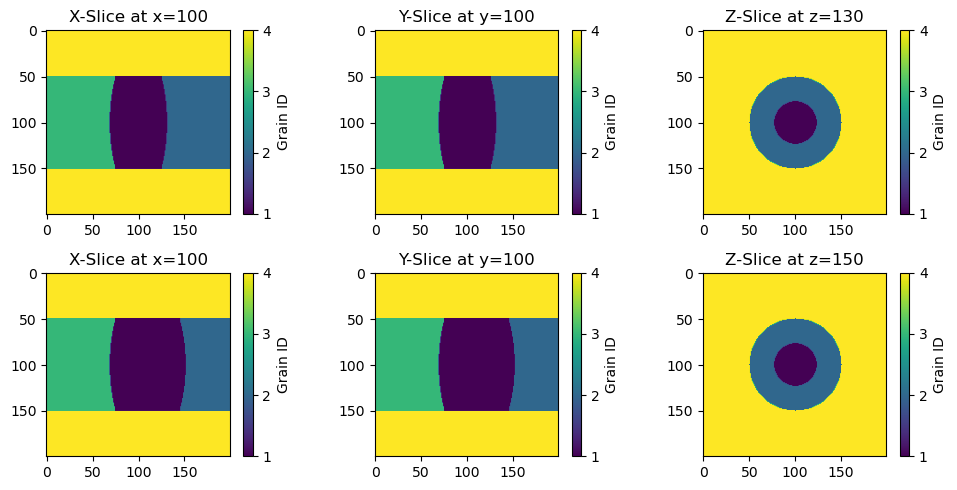

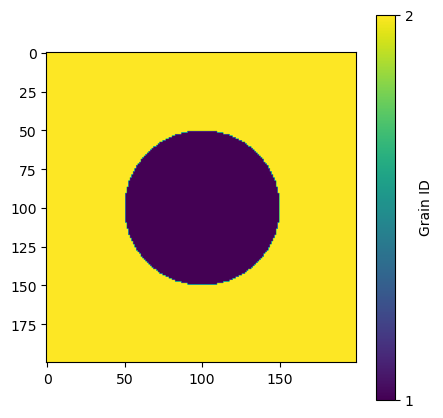

In [128]:
# Visualize mid-slices
plt.figure(figsize=(10, 5))

# X-slice
plt.subplot(231)
plt.imshow(P0_step0[nx//2, :, :], cmap='viridis', vmin=1, vmax=4)
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# Y-slice
plt.subplot(232)
plt.imshow(P0_step0[:, ny//2, :], cmap='viridis', vmin=1, vmax=4)
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# Z-slice at cylinder half-height
plt.subplot(233)
plt.imshow(P0_step0[:, :, start_z_step0 + cylinder_height_step0 + 5], cmap='viridis', vmin=1, vmax=4)
plt.title(f'Z-Slice at z={start_z_step0 + cylinder_height_step0 + 5}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# X-slice
plt.subplot(234)
plt.imshow(P0_step1[nx//2, :, :], cmap='viridis', vmin=1, vmax=4)
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# Y-slice
plt.subplot(235)
plt.imshow(P0_step1[:, ny//2, :], cmap='viridis', vmin=1, vmax=4)
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

# Z-slice at cylinder half-height
plt.subplot(236)
plt.imshow(P0_step1[:, :, start_z_step1 + cylinder_height_step1 + 5], cmap='viridis', vmin=1, vmax=4)
plt.title(f'Z-Slice at z={start_z_step1 + cylinder_height_step1 + 5}')
plt.colorbar(ticks=[1, 2, 3, 4], label='Grain ID')

plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(P0_sphere_step0[nx//2, :, :], cmap='viridis', vmin=1, vmax=2)
plt.colorbar(ticks=[1, 2], label='Grain ID')


## Get curvature result from IO_curvature

In [129]:
import importlib
importlib.reload(post_processing)

# Calculate the curvature dictionary
curvature_dict_IO_step0 = post_processing.IO_curvature(P0_step0)
curvature_dict_IO_step1 = post_processing.IO_curvature(P0_step1)


In [118]:
curvature_dict_IO_step0_sphere = post_processing.IO_curvature(P0_sphere_step0)

In [130]:
print("Curvature matrix shape:", len(curvature_dict_IO_step0))
print("Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)")
for key, value in curvature_dict_IO_step0.items():
    if key == 2:
        print(f"GB id in step 0: {key}, Value: {value}")
for key, value in curvature_dict_IO_step1.items():
    if key == 2:
        print(f"GB id in step 1: {key}, Value: {value}")
# analytical value
analytical_curvature = 1 / GB_radius
print(f"Analytical curvature: {analytical_curvature}, calculated curvature: {round(curvature_dict_IO_step0[2][3],5)} error: {abs(analytical_curvature - curvature_dict_IO_step0[2][3])/analytical_curvature * 100:.2f}%")

Curvature matrix shape: 6
Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)
GB id in step 0: 2, Value: [1.96800000e+03 1.94400000e+03 9.07700000e+03 2.07662839e-03]
GB id in step 1: 2, Value: [1.96800000e+03 1.94400000e+03 9.07700000e+03 2.07662839e-03]
Analytical curvature: 0.005, calculated curvature: 0.00208 error: 58.47%


In [120]:
print("Curvature matrix shape:", len(curvature_dict_IO_step0_sphere))
print("Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)")
for key, value in curvature_dict_IO_step0_sphere.items():
    if key == 2:
        print(f"GB id in step 0: {key}, Value: {value}")
# analytical value
analytical_curvature = 1 / sphere_radius
print(f"Analytical curvature: {analytical_curvature}, calculated curvature: {round(curvature_dict_IO_step0_sphere[2][3],5)} error: {abs(analytical_curvature - curvature_dict_IO_step0_sphere[2][3])/analytical_curvature * 100:.2f}%")

Curvature matrix shape: 1
Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)
GB id in step 0: 2, Value: [2.79240000e+04 2.67360000e+04 4.69500000e+04 1.98733337e-02]
Analytical curvature: 0.02, calculated curvature: 0.01987 error: 0.63%


## Get velocity from IO

In [79]:

def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
    growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
    growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
    return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)

def compute_necessary_info_split(key,time_interval,
                            GB_infomation_dict_list_one_step_one_key,
                            npy_file_aniso_current,
                            npy_file_aniso_next):
    
    
    # Calculate dV and velocity
    dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
    velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
    # keep curvature
    current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
    
    result = {
        "key": key,
        "velocity": velocity,
        "dV_direction1": dV_direction1,
        "dV_direction2": dV_direction2,
        "current_curvature_value": current_curvature_value,
        "is_anti_curvature": current_curvature_value * velocity < -1e-4 # not large difference, no GB in [-1e-4,0]
    }
    
    return result

time_interval = 1
# tmp_GB_infot_key2 = np.array([curvature_dict_IO_step0[2][2],0,0,0,curvature_dict_IO_step0[2][3],curvature_dict_IO_step0[2][2],1,2])
tmp_GB_infot_key2 = np.array([1.51300000e+04,0,0,0,curvature_dict_IO_step0[2][3],1.51300000e+04,1,2])
result = compute_necessary_info_split(key,time_interval,tmp_GB_infot_key2,P0_step0,P0_step1)

print("Velocity:", result["velocity"])
print("dV_direction1:", result["dV_direction1"])
print("dV_direction2:", result["dV_direction2"])
print("Current curvature value:", result["current_curvature_value"])
print("Is anti-curvature:", result["is_anti_curvature"])


Velocity: -31.110376734963648
dV_direction1: 0
dV_direction2: 235350
Current curvature value: -0.0020257448599181847
Is anti-curvature: False


## Get curvature from VECTOR

In [80]:
cores = 8
loop_times = 5
size_x,size_y,size_z = P0_step0.shape
grain_nums = 3
R = np.zeros((size_x,size_y,size_z,4))

smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,P0_step0,R,'p',verification_system = True,curvature_sign = True)
smoothing_class.linear3d_main("curvature")
C_ln = smoothing_class.get_C()
curvature_matrix_step0 = C_ln[1,:]

smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,P0_step1,R,'p',verification_system = True,curvature_sign = True)
smoothing_class.linear3d_main("curvature")
C_ln = smoothing_class.get_C()
curvature_matrix_step1 = C_ln[1,:]


my core time is 11.569291
res_back start...
my res time is 0.018409
my core time is 12.182061
res_back start...
my res time is 0.012689
my core time is 12.604144
res_back start...
my res time is 0.002646
my core time is 14.74288
res_back start...
my res time is 0.007612
my core time is 12.950296
res_back start...
my res time is 0.006007
my core time is 12.258002
res_back start...
my res time is 0.007506
my core time is 11.375129
res_back start...
my res time is 0.002905
my core time is 10.566591
res_back start...
my res time is 0.004603
core done!

my core time is 7.259477
res_back start...
my res time is 0.01781
my core time is 9.169671
res_back start...
my res time is 0.008195
my core time is 9.998364
res_back start...
my res time is 0.002286
my core time is 9.59932
res_back start...
my res time is 0.002334
my core time is 9.882714
res_back start...
my res time is 0.004715
my core time is 9.423722
res_back start...
my res time is 0.004816
my core time is 8.968973
res_back start...
m

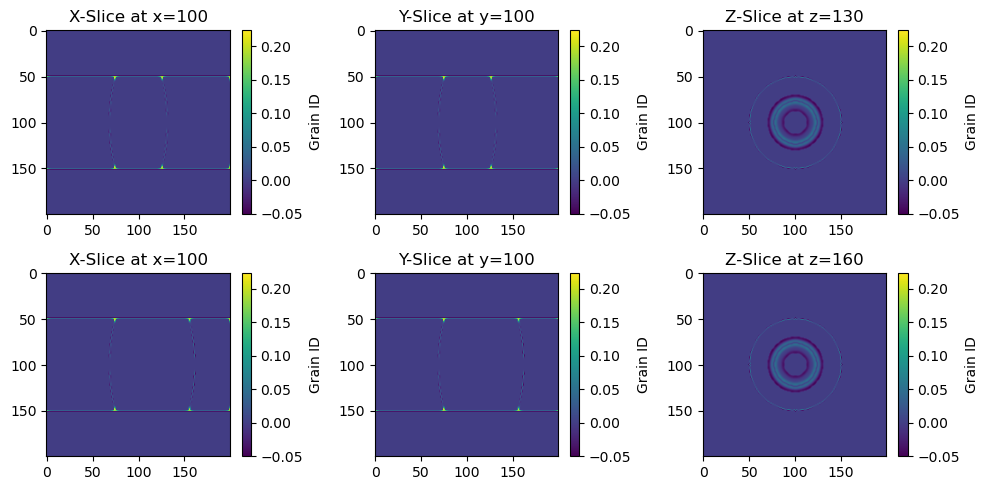

In [81]:
# Visualize mid-slices
plt.figure(figsize=(10, 5))

# curvatrue X-slice 
plt.subplot(231)
plt.imshow(curvature_matrix_step0[nx//2, :, :], cmap='viridis', vmin=np.min(curvature_matrix_step0), vmax=np.max(curvature_matrix_step0))
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(label='Grain ID')

# curvatrue Y-slice
plt.subplot(232)
plt.imshow(curvature_matrix_step0[:, ny//2, :], cmap='viridis', vmin=np.min(curvature_matrix_step0), vmax=np.max(curvature_matrix_step0))
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(label='Grain ID')

# curvatrue Z-slice at cylinder half-height
plt.subplot(233)
plt.imshow(curvature_matrix_step0[:, :, start_z_step0 + cylinder_height_step0 + 5], cmap='viridis', vmin=np.min(curvature_matrix_step0), vmax=np.max(curvature_matrix_step0))
plt.title(f'Z-Slice at z={start_z_step0 + cylinder_height_step0 + 5}')
plt.colorbar(label='Grain ID')

# curvatrue X-slice 
plt.subplot(234)
plt.imshow(curvature_matrix_step1[nx//2, :, :], cmap='viridis', vmin=np.min(curvature_matrix_step1), vmax=np.max(curvature_matrix_step1))
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(label='Grain ID')

# curvatrue Y-slice
plt.subplot(235)
plt.imshow(curvature_matrix_step1[:, ny//2, :], cmap='viridis', vmin=np.min(curvature_matrix_step1), vmax=np.max(curvature_matrix_step1))
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(label='Grain ID')

# curvatrue Z-slice at cylinder half-height
plt.subplot(236)
plt.imshow(curvature_matrix_step1[:, :, start_z_step1 + cylinder_height_step1 + 5], cmap='viridis', vmin=np.min(curvature_matrix_step1), vmax=np.max(curvature_matrix_step1))
plt.title(f'Z-Slice at z={start_z_step1 + cylinder_height_step1 + 5}')
plt.colorbar(label='Grain ID')

plt.tight_layout()
plt.show()


In [82]:
from collections import defaultdict
from scipy.spatial import cKDTree

TJ_distance_max = 5

# Create shifted arrays for all 6 directions at once
neighbors = np.stack([
    np.roll(P0_step0, -1, axis=0),
    np.roll(P0_step0, 1, axis=0),
    np.roll(P0_step0, -1, axis=1),
    np.roll(P0_step0, 1, axis=1),
    np.roll(P0_step0, -1, axis=2),
    np.roll(P0_step0, 1, axis=2)
])

# Find boundary voxels efficiently
boundary_mask = (neighbors != P0_step0[None,...]).any(axis=0)
boundary_coords = np.argwhere(boundary_mask)

# First pass: Build TJ_information_dict and organize TJ points by pair_id
TJ_infomation_dict = defaultdict(list)
TJ_trees = {}  # KD-trees for each pair_id's TJ points
neighbor_array = neighbors.reshape(6, -1).T

# Process boundary points for triple junctions
for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0_step0[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])
    
    if len(unique_neighbors) > 1:  # Triple junction point
        for neighbor in unique_neighbors:
            pair_id = post_processing.get_line(central_site, neighbor)
            TJ_infomation_dict[pair_id].append([i,j,k])
print("Finish TJ information collection")
# Create KD-trees for each pair_id's TJ points
for pair_id, tj_points in TJ_infomation_dict.items():
    tj_points_array = np.array(tj_points)
    TJ_trees[pair_id] = cKDTree(tj_points_array)

# Second pass: Build GB_information_dict
GB_infomation_dict = {}

# Process boundary points for grain boundaries
# Group boundary points by pair_id for batch processing
gb_points_by_pair = defaultdict(list)
gb_central_sites = defaultdict(list)
gb_indices = defaultdict(list)

for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0_step0[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])
    
    if len(unique_neighbors) == 1:  # Single boundary point
        neighbor = unique_neighbors[0]
        pair_id = post_processing.get_line(central_site, neighbor)
        pair_id_pair = sorted([central_site, neighbor])
        
        # First update or create GB area count
        if pair_id in GB_infomation_dict:
            GB_infomation_dict[pair_id][5] += 1  # Only update area counter first
        else:
            GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]])  # Initialize with zeros
            GB_infomation_dict[pair_id] = GB_infomation
        
        # Collect points for batch processing
        gb_points_by_pair[pair_id].append([i,j,k])
        gb_central_sites[pair_id].append(central_site)
        gb_indices[pair_id].append([i,j,k])
print("Finish GB information collection")

# Process each pair_id's points in batch
for pair_id, points in gb_points_by_pair.items():
    points_array = np.array(points)
    central_sites = np.array(gb_central_sites[pair_id])
    indices = np.array(gb_indices[pair_id])
    
    # If there are TJ points for this pair_id, check distances
    if pair_id in TJ_trees:
        # Find distances to nearest TJ points for all GB points at once
        distances, _ = TJ_trees[pair_id].query(points_array)
        # Create mask for points far enough from TJ
        far_from_tj_mask = distances >= TJ_distance_max
        
        # Process only points far from TJ
        valid_points = points_array[far_from_tj_mask]
        valid_central_sites = central_sites[far_from_tj_mask]
        valid_indices = indices[far_from_tj_mask]
        
        # Update GB information for valid points
        n_valid = len(valid_points)
        if n_valid == 0: continue
        GB_infomation_dict[pair_id][0] += n_valid
        
        # Calculate curvature signs based on central_site matching pair_id_pair[0]
        curvature_signs = np.where(valid_central_sites == GB_infomation_dict[pair_id][6], 1, -1)
        
        # Update position and curvature information
        pos_ave = np.sum(valid_indices, axis=0) / n_valid
        curv_ave = np.sum(curvature_signs * curvature_matrix_step0[valid_points[:,0], valid_points[:,1], valid_points[:,2]]) / n_valid
        GB_infomation_dict[pair_id][1:4] += pos_ave
        GB_infomation_dict[pair_id][4] += curv_ave
print("Finsh GB information dictionary")

# Post-process GB information
GB_infomation_dict = {k:v for k,v in GB_infomation_dict.items() if v[0] != 0}

print(f"Current GBs len: {len(GB_infomation_dict)}")

GB_infomation_dict_step0 = GB_infomation_dict.copy()

Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary
Current GBs len: 6


In [83]:
from collections import defaultdict
from scipy.spatial import cKDTree

TJ_distance_max = 5

# Create shifted arrays for all 6 directions at once
neighbors = np.stack([
    np.roll(P0_step1, -1, axis=0),
    np.roll(P0_step1, 1, axis=0),
    np.roll(P0_step1, -1, axis=1),
    np.roll(P0_step1, 1, axis=1),
    np.roll(P0_step1, -1, axis=2),
    np.roll(P0_step1, 1, axis=2)
])

# Find boundary voxels efficiently
boundary_mask = (neighbors != P0_step1[None,...]).any(axis=0)
boundary_coords = np.argwhere(boundary_mask)

# First pass: Build TJ_information_dict and organize TJ points by pair_id
TJ_infomation_dict = defaultdict(list)
TJ_trees = {}  # KD-trees for each pair_id's TJ points
neighbor_array = neighbors.reshape(6, -1).T

# Process boundary points for triple junctions
for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0_step1[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])
    
    if len(unique_neighbors) > 1:  # Triple junction point
        for neighbor in unique_neighbors:
            pair_id = post_processing.get_line(central_site, neighbor)
            TJ_infomation_dict[pair_id].append([i,j,k])
print("Finish TJ information collection")
# Create KD-trees for each pair_id's TJ points
for pair_id, tj_points in TJ_infomation_dict.items():
    tj_points_array = np.array(tj_points)
    TJ_trees[pair_id] = cKDTree(tj_points_array)

# Second pass: Build GB_information_dict
GB_infomation_dict = {}

# Process boundary points for grain boundaries
# Group boundary points by pair_id for batch processing
gb_points_by_pair = defaultdict(list)
gb_central_sites = defaultdict(list)
gb_indices = defaultdict(list)

for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0_step1[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])
    
    if len(unique_neighbors) == 1:  # Single boundary point
        neighbor = unique_neighbors[0]
        pair_id = post_processing.get_line(central_site, neighbor)
        pair_id_pair = sorted([central_site, neighbor])
        
        # First update or create GB area count
        if pair_id in GB_infomation_dict:
            GB_infomation_dict[pair_id][5] += 1  # Only update area counter first
        else:
            GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]])  # Initialize with zeros
            GB_infomation_dict[pair_id] = GB_infomation
        
        # Collect points for batch processing
        gb_points_by_pair[pair_id].append([i,j,k])
        gb_central_sites[pair_id].append(central_site)
        gb_indices[pair_id].append([i,j,k])
print("Finish GB information collection")

# Process each pair_id's points in batch
for pair_id, points in gb_points_by_pair.items():
    points_array = np.array(points)
    central_sites = np.array(gb_central_sites[pair_id])
    indices = np.array(gb_indices[pair_id])
    
    # If there are TJ points for this pair_id, check distances
    if pair_id in TJ_trees:
        # Find distances to nearest TJ points for all GB points at once
        distances, _ = TJ_trees[pair_id].query(points_array)
        # Create mask for points far enough from TJ
        far_from_tj_mask = distances >= TJ_distance_max
        
        # Process only points far from TJ
        valid_points = points_array[far_from_tj_mask]
        valid_central_sites = central_sites[far_from_tj_mask]
        valid_indices = indices[far_from_tj_mask]
        
        # Update GB information for valid points
        n_valid = len(valid_points)
        if n_valid == 0: continue
        GB_infomation_dict[pair_id][0] += n_valid
        
        # Calculate curvature signs based on central_site matching pair_id_pair[0]
        curvature_signs = np.where(valid_central_sites == GB_infomation_dict[pair_id][6], 1, -1)
        
        # Update position and curvature information
        pos_ave = np.sum(valid_indices, axis=0) / n_valid
        curv_ave = np.sum(curvature_signs * curvature_matrix_step1[valid_points[:,0], valid_points[:,1], valid_points[:,2]]) / n_valid
        GB_infomation_dict[pair_id][1:4] += pos_ave
        GB_infomation_dict[pair_id][4] += curv_ave
print("Finsh GB information dictionary")

# Post-process GB information
GB_infomation_dict = {k:v for k,v in GB_infomation_dict.items() if v[0] != 0}

print(f"Current GBs len: {len(GB_infomation_dict)}")

GB_infomation_dict_step1 = GB_infomation_dict.copy()

Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary
Current GBs len: 6


In [84]:
print("Curvature matrix shape:", len(GB_infomation_dict))
print("Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)")
for key, value in GB_infomation_dict_step0.items():
    if key == 2:
        print(f"GB id in step 0: {key}, Value: {value}")
for key, value in GB_infomation_dict_step1.items():
    if key == 2:
        print(f"GB id in step 1: {key}, Value: {value}")
# analytical value
analytical_curvature = 1 / GB_radius
print(f"Analytical curvature: {analytical_curvature}, calculated curvature: {round(GB_infomation_dict[2][4],5)} error: {abs(analytical_curvature - GB_infomation_dict[2][4])/analytical_curvature * 100:.2f}%")

Curvature matrix shape: 6
Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)
GB id in step 0: 2, Value: [1.25700000e+04 1.00000000e+02 1.00000000e+02 1.28835243e+02
 5.18224827e-03 1.51300000e+04 1.00000000e+00 2.00000000e+00]
GB id in step 1: 2, Value: [1.25700000e+04 1.00000000e+02 1.00000000e+02 1.58835243e+02
 5.18224827e-03 1.51300000e+04 1.00000000e+00 2.00000000e+00]
Analytical curvature: 0.005, calculated curvature: 0.00518 error: 3.64%


# get velocity from VECTOR

In [86]:

def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
    growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
    growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
    return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)

def compute_necessary_info_split(key,time_interval,
                            GB_infomation_dict_list_one_step_one_key,
                            npy_file_aniso_current,
                            npy_file_aniso_next):
    
    
    # Calculate dV and velocity
    dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
    velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
    # keep curvature
    current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
    
    result = {
        "key": key,
        "velocity": velocity,
        "dV_direction1": dV_direction1,
        "dV_direction2": dV_direction2,
        "current_curvature_value": current_curvature_value,
        "is_anti_curvature": current_curvature_value * velocity < -1e-4 # not large difference, no GB in [-1e-4,0]
    }
    
    return result

time_interval = 1
result = compute_necessary_info_split(key,time_interval,GB_infomation_dict[2],P0_step0,P0_step1)

print("Velocity:", result["velocity"])
print("dV_direction1:", result["dV_direction1"])
print("dV_direction2:", result["dV_direction2"])
print("Current curvature value:", result["current_curvature_value"])
print("Is anti-curvature:", result["is_anti_curvature"])


Velocity: -31.110376734963648
dV_direction1: 0
dV_direction2: 235350
Current curvature value: 0.005182248269570522
Is anti-curvature: True
